##### Copyright 2020 Google

# Quickstart

This code tutorial shows how to estimate a 1-RDM and perform variational optimization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/hfvqe/quickstart"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/hfvqe/quickstart.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/hfvqe/quickstart.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/hfvqe/quickstart.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [10]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq
    

In [11]:
import numpy as np
import cirq

from recirq.hfvqe.gradient_hf import rhf_func_generator
from recirq.hfvqe.opdm_functionals import OpdmFunctional
from recirq.hfvqe.analysis import (
    compute_opdm, mcweeny_purification,
    resample_opdm, fidelity_witness,
    fidelity)
from recirq.hfvqe.third_party.higham import fixed_trace_positive_projection
from recirq.hfvqe.molecular_example import make_h6_1_3
from cirq.contrib.svg import SVGCircuit

## Set up the experiment

Generate the input files, set up quantum resources, and set up the OpdmFunctional to make measurements. 

In [12]:
rhf_objective, molecule, parameters, obi, tbi = make_h6_1_3()

Optimization terminated successfully.
         Current function value: -2.924060
         Iterations: 7
         Function evaluations: 15
         Gradient evaluations: 15


In [13]:
ansatz, energy, gradient = rhf_func_generator(rhf_objective)

In [14]:
# settings for quantum resources
qubits = [cirq.GridQubit(0, x) for x in range(molecule.n_orbitals)]
sampler = cirq.Simulator(dtype=np.complex128)  # this can be a QuantumEngine

# OpdmFunctional contains an interface for running experiments
opdm_func = OpdmFunctional(qubits=qubits,
                           sampler=sampler,
                           constant=molecule.nuclear_repulsion,
                           one_body_integrals=obi,
                           two_body_integrals=tbi,
                           # only simulate spin-up electrons:
                           num_electrons=molecule.n_electrons // 2,
                           clean_xxyy=True,
                           purification=False
                           )

The displayed text is the output of the gradient based restricted Hartree-Fock.  We define the gradient in `rhf_objective` and use the conjugate-gradient optimizer to optimize the basis rotation parameters.  This is equivalent to doing Hartree-Fock theory from the canonical transformation perspective.

## Estimate Quantities

Next, we will do the following:

1. Do measurements for a given set of parameters

2. Compute 1-RDM, variances, and purification

3. Compute energy, fidelities, and errorbars

In [15]:
# 1.
# default to 250_000 shots for each circuit.
# 7 circuits total, printed for your viewing pleasure
# return value is a dictionary with circuit results for each permutation
measurement_data = opdm_func.calculate_data(parameters)

# 2.
opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
opdm_pure = mcweeny_purification(opdm)

# 3.
raw_energies = []
raw_fidelity_witness = []
purified_eneriges = []
purified_fidelity_witness = []
purified_fidelity = []
true_unitary = ansatz(parameters)
nocc = molecule.n_electrons // 2
nvirt = molecule.n_orbitals - nocc
initial_fock_state = [1] * nocc + [0] * nvirt

# 1000 repetitions of the measurement
for _ in range(1000):  
    new_opdm = resample_opdm(opdm, var_dict)
    raw_energies.append(opdm_func.energy_from_opdm(new_opdm))
    raw_fidelity_witness.append(
        fidelity_witness(target_unitary=true_unitary,
                         omega=initial_fock_state,
                         measured_opdm=new_opdm)
    )
    # fix positivity and trace of sampled 1-RDM if strictly outside
    # feasible set
    w, v = np.linalg.eigh(new_opdm)
    if len(np.where(w < 0)[0]) > 0:
        new_opdm = fixed_trace_positive_projection(new_opdm, nocc)

    new_opdm_pure = mcweeny_purification(new_opdm)
    purified_eneriges.append(opdm_func.energy_from_opdm(new_opdm_pure))
    purified_fidelity_witness.append(
        fidelity_witness(target_unitary=true_unitary,
                         omega=initial_fock_state,
                         measured_opdm=new_opdm_pure)
    )
    purified_fidelity.append(
        fidelity(target_unitary=true_unitary,
                 measured_opdm=new_opdm_pure)
    )
print("Canonical Hartree-Fock energy ", molecule.hf_energy)
print("True energy ", energy(parameters))
print("Raw energy ", opdm_func.energy_from_opdm(opdm),
      "+- ", np.std(raw_energies))
print("Raw fidelity witness ", np.mean(raw_fidelity_witness).real,
      "+- ", np.std(raw_fidelity_witness))
print("purified energy ", opdm_func.energy_from_opdm(opdm_pure),
      "+- ", np.std(purified_eneriges))
print("Purified fidelity witness ", np.mean(purified_fidelity_witness).real,
      "+- ", np.std(purified_fidelity_witness))
print("Purified fidelity ", np.mean(purified_fidelity).real,
      "+- ", np.std(purified_fidelity))

/tmp/ipykernel_13854/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmp/ipykernel_13854/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmp/ipykernel_13854/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmp/ipykernel_13854/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmp/ipykernel_13854/2348574811.py:8: DeprecationWarning: `alltr

Canonical Hartree-Fock energy  -2.9240604849733085
True energy  -2.924060484972228
Raw energy  -2.9267581412974373 +-  0.0015169579147688017
Raw fidelity witness  1.0035978175763183 +-  0.002070926651119044
purified energy  -2.924057164354299 +-  5.322308816987647e-06
Purified fidelity witness  0.9999829614891131 +-  7.341966857740764e-06
Purified fidelity  0.999991481076193 +-  3.6709467772074223e-06


This prints out the various energies estimated from the 1-RDM along with error bars.  Generated from resampling the 1-RDM based on the estimated covariance.

## Optimization

We use the sampling functionality to variationally relax the parameters of
my ansatz such that the energy is decreased.

For this we will need the augmented Hessian optimizer

The optimizerer code we have takes:
rhf_objective object, initial parameters,
a function that takes a n x n unitary and returns an opdm
maximum iterations,
hassian_update which indicates how much of the hessian to use
rtol which is the gradient stopping condition.

A natural thing that we will want to save is the variance dictionary of
the non-purified 1-RDM.  This is accomplished by wrapping the 1-RDM
estimation code in another object that keeps track of the variance 
dictionaries. 


In [16]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq
import numpy as np
import cirq

from recirq.hfvqe.gradient_hf import rhf_func_generator
from recirq.hfvqe.opdm_functionals import OpdmFunctional
from recirq.hfvqe.analysis import (
    compute_opdm, mcweeny_purification,
    resample_opdm, fidelity_witness,
    fidelity)
from recirq.hfvqe.third_party.higham import fixed_trace_positive_projection
from recirq.hfvqe.molecular_example import make_h6_1_3
from cirq.contrib.svg import SVGCircuit

In [17]:
from recirq.hfvqe.mfopt import moving_frame_augmented_hessian_optimizer
from recirq.hfvqe.opdm_functionals import RDMGenerator

rdm_generator = RDMGenerator(opdm_func, purification=False)
opdm_generator = rdm_generator.opdm_generator

result = moving_frame_augmented_hessian_optimizer(
    rhf_objective=rhf_objective,
    initial_parameters=parameters + 1.0E-1,
    opdm_aa_measurement_func=opdm_generator,
    verbose=True, delta=0.03,
    max_iter=20,
    hessian_update='diagonal',
    rtol=0.50E-2)


ITERATION NUMBER :  0

 unitary
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Current Energy:  -2.826988975652606
true energy  -2.826271292768161
dvec
[((0.1314575945696+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.15069906644743727+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.11511477909831505+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((0.3374643358010291+0j), -1.0 [0^ 8] +
-1.0 [1^ 9] +
1.0 [8^ 0] +
1.0 [9^ 1]), ((0.14273785613145873+0j), -1.0 [2^ 8] +
-1.0 [3^ 9] +
1.0 [8^ 2] +
1.0 [9^ 3]), ((0.26355507998173444+0j), -1.0 [4^ 8] +
-1.0 [5^ 9] +
1.0 [8^ 4] +
1.0 [9^ 5]), ((0.1976492929955989+0j), -1.0 [0^ 10] +
-1.0 [1^ 11] +
1.0 [10^ 0] +
1.0 [11^ 1]), ((0.21991417663354507+0j), -1.0 [2^ 10] +
-1.0 [3^ 11] +
1.0 [10^ 2] +
1.0 [11^ 3]), ((0.2290629240593344+0j), -1.0 [4^ 10] +
-1.0 [5^ 11] +
1.0 [10^ 4] +
1.0 [11^ 5])]
New fr values norm
0.05158407788

Each iteration prints out a variety of information that the user might find useful.  Watching energies go down is known to be one of the best forms of entertainment during a shelter-in-place order.

After the optimization we can print the energy as a function of iteration number to see close the energy gets to the true minium.

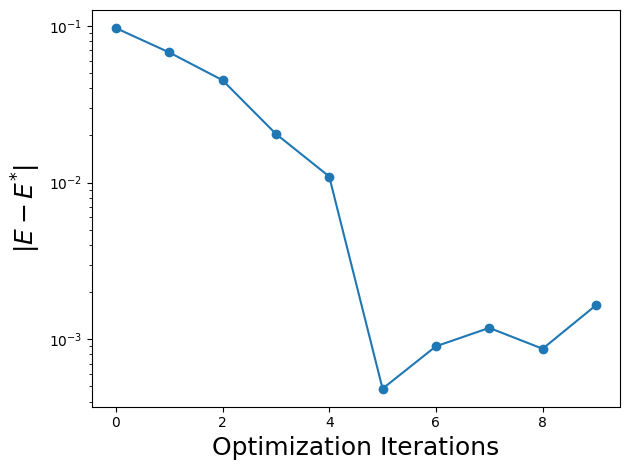

In [18]:
import matplotlib.pyplot as plt

plt.semilogy(range(len(result.func_vals)),
             np.abs(np.array(result.func_vals) - energy(parameters)),
             'C0o-')
plt.xlabel("Optimization Iterations",  fontsize=18)
plt.ylabel(r"$|E  - E^{*}|$", fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
energy(parameters)